In [1]:
# impotamos librerias a utilizar
import numpy as np
import matplotlib.pyplot as plt
import torch
import scipy.io as sio
import random

In [2]:
# Cargar el archivo MAT
emnist_digits = sio.loadmat('emnist-digits.mat')

In [3]:
# cargamos las caracteristicas de emnist de entrenamiento
X_train = emnist_digits["dataset"]["train"][0][0]["images"][0][0].astype('float64') 
print("Shape X_train: ", X_train.shape)
# cargamos las etiquetas de emnist de entrenamiento
y_train = emnist_digits["dataset"]["train"][0][0]["labels"][0][0].ravel().astype('int64')
print("Shape y_train: ", y_train.shape)

# cargamos las caracteristicas de emnist de prueba
X_test = emnist_digits["dataset"]["test"][0][0]["images"][0][0].astype('float64') 
print("Shape X_test: ", X_test.shape)
# cargamos las etiquetas de emnist de prueba
y_test = emnist_digits["dataset"]["test"][0][0]["labels"][0][0].ravel().astype('int64')
print("Shape y_test: ", y_test.shape)

Shape X_train:  (240000, 784)
Shape y_train:  (240000,)
Shape X_test:  (40000, 784)
Shape y_test:  (40000,)


In [4]:
X_train.dtype, y_train.dtype

(dtype('float64'), dtype('int64'))

In [5]:
y_train = y_train.astype(np.int32)

In [6]:
# mostramos las clases
print('y_train clases: ', np.unique(y_train))
print('y_test clases: ', np.unique(y_test))

y_train clases:  [0 1 2 3 4 5 6 7 8 9]
y_test clases:  [0 1 2 3 4 5 6 7 8 9]


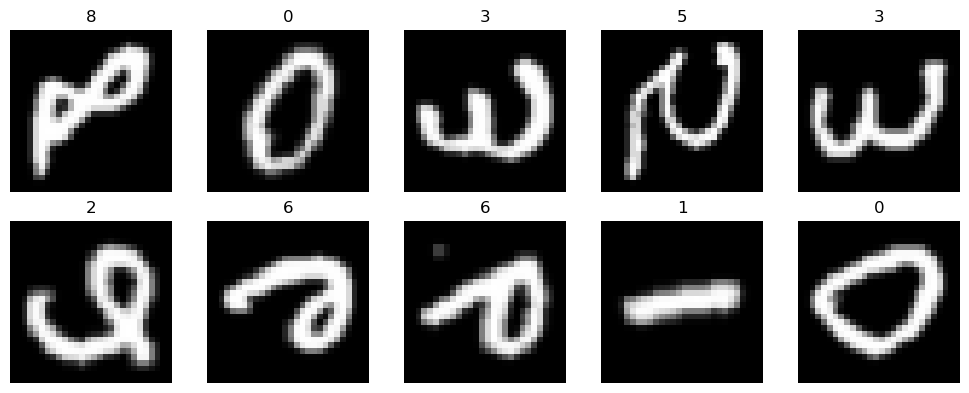

In [7]:
r, c = 2, 5
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(X_train)-1)
        img = X_train[ix]
        plt.imshow(img.reshape(28,28), cmap='gray')
        plt.axis("off")
        plt.title(y_train[ix])
plt.tight_layout()
plt.show()

In [13]:
# normalizamos las caracteristicas
X_train = X_train / 255.0
X_test = X_test / 255.0

In [16]:
X_t = torch.from_numpy(X_train).float().cuda()
Y_t = torch.from_numpy(y_train).long().cuda()

In [22]:
from sklearn.metrics import accuracy_score

def evaluate(x):
    model.eval()
    y_pred = model(x)
    y_probas = softmax(y_pred)
    return torch.argmax(y_probas, axis=1)

def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis=-1,keepdims=True)

def calculate_accuracy(model, X_t):
    correct = 0
    total = 0

    with torch.no_grad():
        y_pred = model(X_t)
        _, predicted = torch.max(y_pred.data, 1)
        total = X_t.size(0)
        correct = predicted.sum().item()

    accuracy = correct / total
    return accuracy

In [28]:
D_in, H, D_out = 784, 70, 10
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out)
).to("cuda")

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.7)

epochs = 100
log_each = 10
l = []
accuracy_values = []
model.train()
for e in range(1, epochs+1):

    # forward
    y_pred = model(X_t)

    # loss
    loss = criterion(y_pred, Y_t)
    l.append(loss.item())

    # ponemos a cero los gradientes
    optimizer.zero_grad()

    # Backprop (calculamos todos los gradientes automáticamente)
    loss.backward()

    # update de los pesos
    optimizer.step()

    if not e % log_each:
        accuracy = calculate_accuracy(model, X_t)
        print(f"Epoch {e}/{epochs} loss {loss.item():.5f} accuracy {accuracy:.4f}")
    
    l.append(loss.item())
    accuracy_values.append(accuracy)

y_pred = evaluate(torch.from_numpy(X_test).float().cuda())
accuracy_score(y_test, y_pred.cpu().numpy())

Epoch 10/100 loss 2.04450 accuracy 3.1633
Epoch 20/100 loss 2.10493 accuracy 3.5285
Epoch 30/100 loss 2.04488 accuracy 3.4380
Epoch 40/100 loss 1.93987 accuracy 4.4410
Epoch 50/100 loss 1.79375 accuracy 4.4209
Epoch 60/100 loss 1.67570 accuracy 5.6273
Epoch 70/100 loss 1.52937 accuracy 2.8714
Epoch 80/100 loss 2.45842 accuracy 3.1380
Epoch 90/100 loss 1.71784 accuracy 4.5313
Epoch 100/100 loss 1.22103 accuracy 5.0995


0.5579

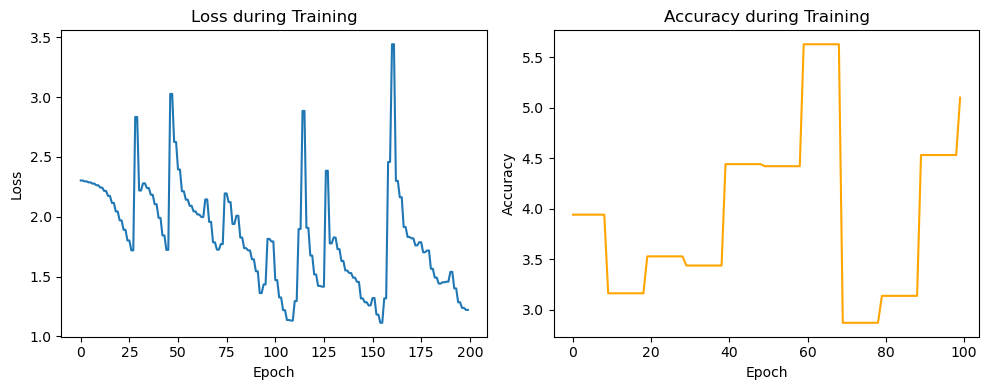

In [29]:
def plot_loss_and_accuracy(loss_values, accuracy_values):
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(l)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss during Training')

    plt.subplot(1, 2, 2)
    plt.plot(accuracy_values, color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy during Training')

    plt.tight_layout()
    plt.show()

# Llamamos a la función para dibujar
plot_loss_and_accuracy(loss_values, accuracy_values)

In [63]:
# Guardar el estado del modelo
torch.save(model.state_dict(), 'modelo_entrenado.pth')